In [2]:

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests #The requests library for HTTP requests in Python
import math #The Python math module
import re
import statsmodels.api as sm


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib import cycler

In [56]:
ticker = yf.Ticker("MELI")

In [57]:
df = ticker.history(period="max")

In [58]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2007-08-10 00:00:00-04:00,21.317946,28.100929,20.348949,27.616430,9800300,0.0,0.0
2007-08-13 00:00:00-04:00,30.232730,38.440138,28.100934,30.668777,3162100,0.0,0.0
2007-08-14 00:00:00-04:00,31.443980,31.686229,29.050554,29.099005,609300,0.0,0.0
2007-08-15 00:00:00-04:00,29.273420,29.273420,27.180385,27.674574,991800,0.0,0.0
2007-08-16 00:00:00-04:00,27.374183,29.069929,24.283080,27.228834,1107500,0.0,0.0


In [59]:
df.reset_index(inplace=True)

In [60]:
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2007-08-10 00:00:00-04:00,21.317946,28.100929,20.348949,27.616430,9800300,0.0,0.0
1,2007-08-13 00:00:00-04:00,30.232730,38.440138,28.100934,30.668777,3162100,0.0,0.0
2,2007-08-14 00:00:00-04:00,31.443980,31.686229,29.050554,29.099005,609300,0.0,0.0
3,2007-08-15 00:00:00-04:00,29.273420,29.273420,27.180385,27.674574,991800,0.0,0.0
4,2007-08-16 00:00:00-04:00,27.374183,29.069929,24.283080,27.228834,1107500,0.0,0.0


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4144 entries, 0 to 4143
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype                           
---  ------        --------------  -----                           
 0   Date          4144 non-null   datetime64[ns, America/New_York]
 1   Open          4144 non-null   float64                         
 2   High          4144 non-null   float64                         
 3   Low           4144 non-null   float64                         
 4   Close         4144 non-null   float64                         
 5   Volume        4144 non-null   int64                           
 6   Dividends     4144 non-null   float64                         
 7   Stock Splits  4144 non-null   float64                         
dtypes: datetime64[ns, America/New_York](1), float64(6), int64(1)
memory usage: 259.1 KB


<AxesSubplot: title={'center': 'Stock price'}, xlabel='Date'>

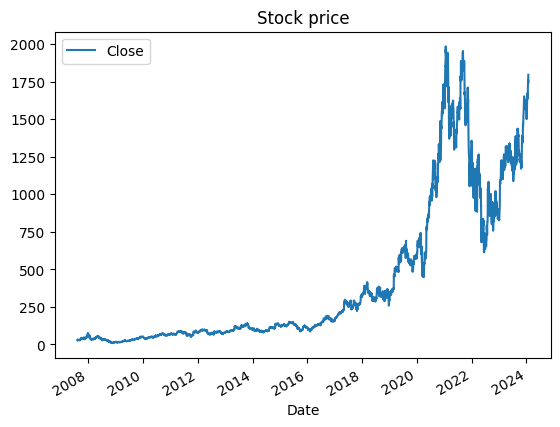

In [62]:
df.plot(x="Date", y="Close", title= 'Stock price')

In [63]:
ticker.balance_sheet

,2022-12-31,2021-12-31,2020-12-31
Ordinary Shares Number,50257751.0,50418980.0,49869727.0
Share Issued,50257751.0,50418980.0,49869727.0
Net Debt,2797000000.0,887000000.0,NaN
Total Debt,5414000000.0,3982000000.0,1708116000.0
Tangible Book Value,1649000000.0,1338000000.0,1552212000.0
...,...,...,...
Allowance For Doubtful Accounts Receivable,-14000000.0,-8000000.0,-7294000.0
Gross Accounts Receivable,144000000.0,106000000.0,56985000.0
Cash Cash Equivalents And Short Term Investments,3030000000.0,2793000000.0,2460751000.0
Other Short Term Investments,1120000000.0,208000000.0,604357000.0


In [64]:
data = df[['Date', 'Close']].copy()

Let's to transform to logarithm

In [65]:
data['Close'] = np.log(df['Close'])

In [66]:
data.head()

,Date,Close
0,2007-08-10 00:00:00-04:00,3.318411
1,2007-08-13 00:00:00-04:00,3.423245
2,2007-08-14 00:00:00-04:00,3.370704
3,2007-08-15 00:00:00-04:00,3.320514
4,2007-08-16 00:00:00-04:00,3.304276


<AxesSubplot: title={'center': 'log Stock price'}, xlabel='Date'>

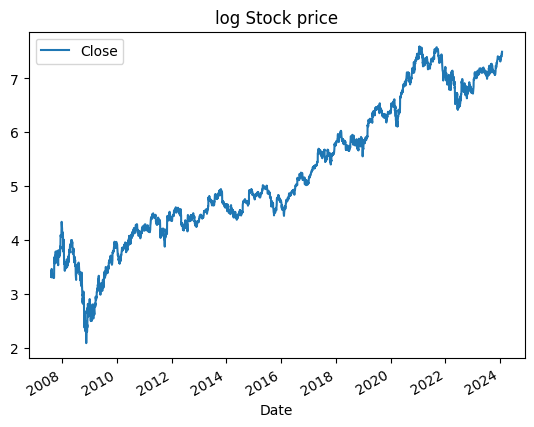

In [67]:
data.plot(x="Date", y="Close", title= 'log Stock price')

Split the dataset train and test


In [68]:
train_data = data[:int(0.8*(len(data)))]
test_data = data[int(0.8*(len(data))):]

Step 1: Check for stationary of time series

Autocorrelation 

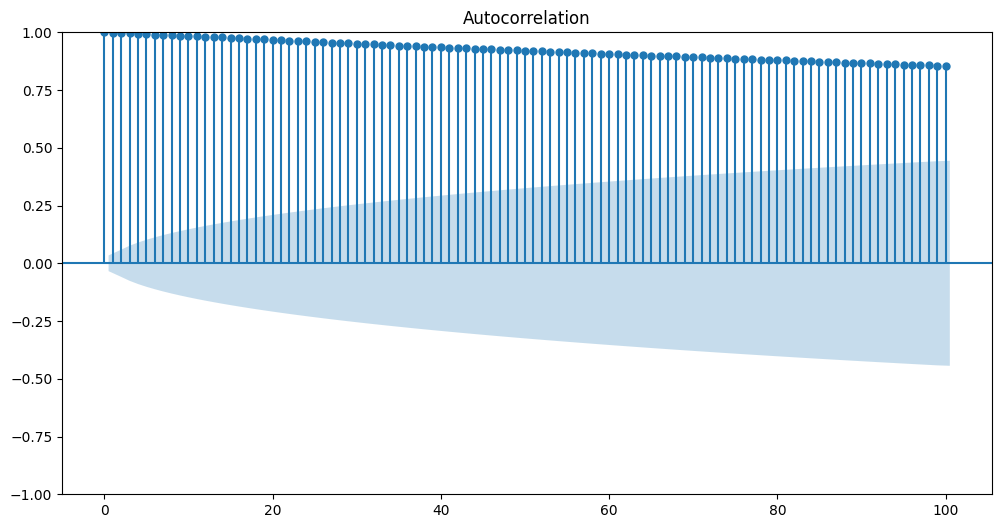

In [69]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plot_acf(train_data['Close'], lags=100)
fig.set_size_inches(12, 6)

The ACF plot shows that the correlations with the lags are high and positive with slow decay. 

Partial autocorrelation 

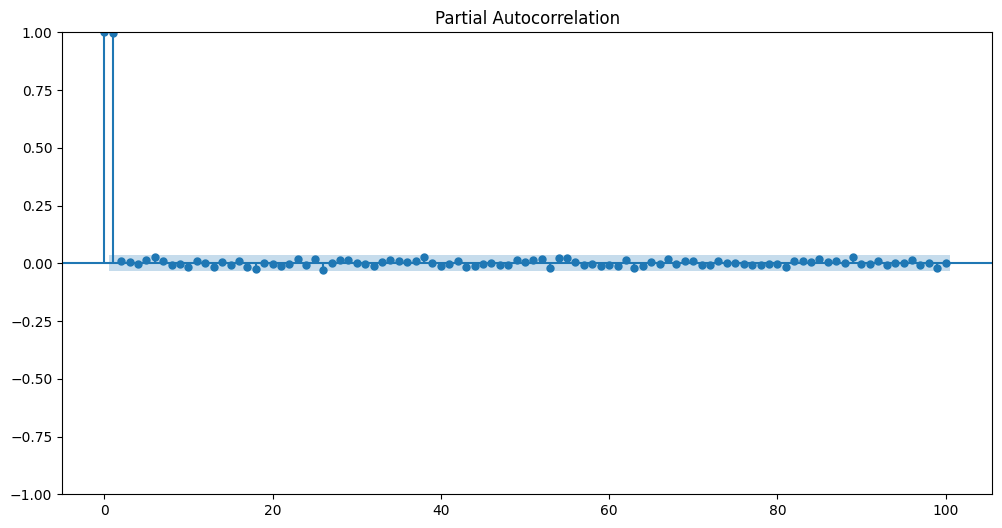

In [70]:
fig = plot_pacf(train_data['Close'], lags=100)
fig.set_size_inches(12, 6)

The PACF plot shows the partial autocorrelations having a single spike at the lag one. These are both signs of a random walk series wich is not stationary. 

Next, we can see the trend

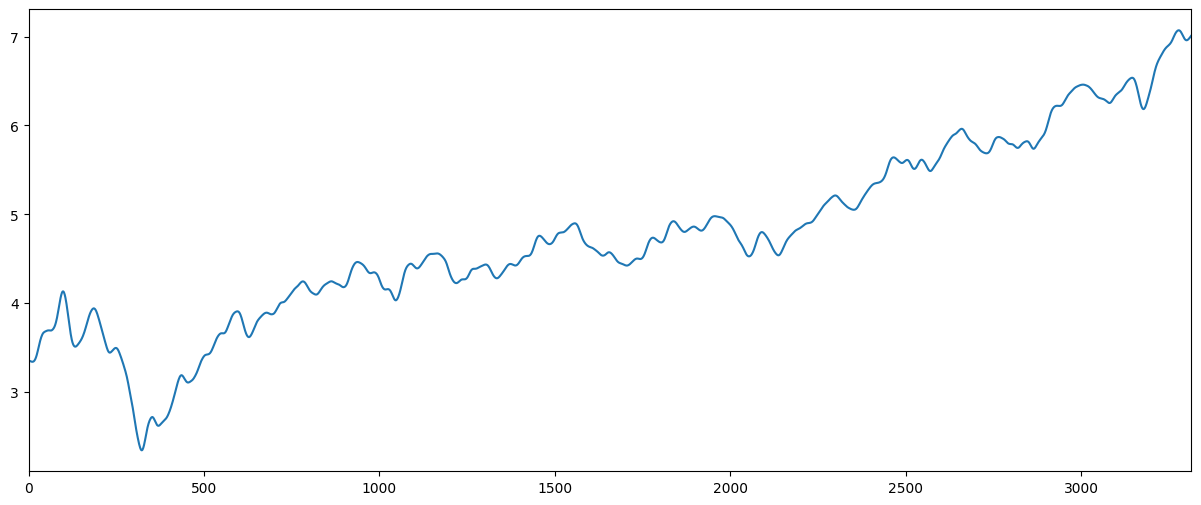

In [71]:
ticker_cycle,ticker_trend = hpfilter(train_data['Close'], lamb=1600)
ticker_trend.plot(figsize=(15,6)).autoscale(axis='x',tight=True)

Separate the trend and cyclical components
from time series data by removing short-term fluctuations from the longer-term trend.

C:\Users\julie\AppData\Local\Temp\ipykernel_14484\3108711848.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['trend'] = ticker_trend
C:\Users\julie\AppData\Local\Temp\ipykernel_14484\3108711848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['cycle'] = ticker_cycle


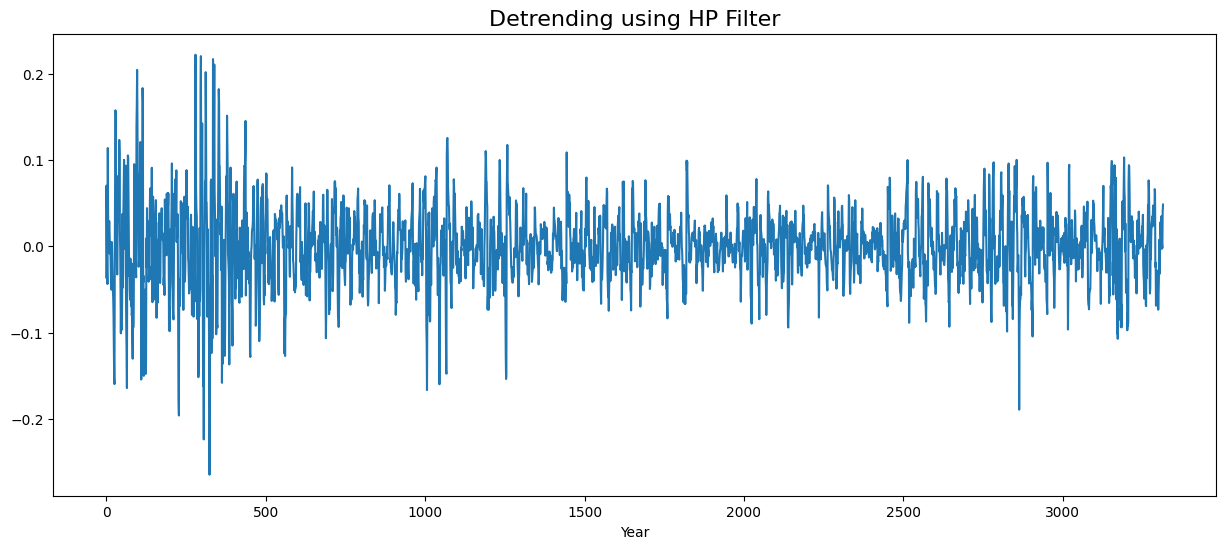

In [72]:
train_data['trend'] = ticker_trend
train_data['cycle'] = ticker_cycle

detrended = train_data.Close - train_data['trend']
plt.figure(figsize=(15,6))
plt.plot(detrended)
plt.title('Detrending using HP Filter', fontsize=16)
plt.xlabel('Year')
plt.show()

We can also check the stationarity with statistical test like the ADF test. The augmented Dickey–Fuller test (ADF) tests the null hypothesis that a unit root is present in a time series sample so non-stationarity.  

In [73]:

result = adfuller(train_data['Close'])
print('Test Stat: {}\np value: {}\nLags: {}\nNum \
       observations: {}'.format(result[0], result[1], 
                                result[2], result[3]))

Test Stat: -0.08491896173242086
p value: 0.9509200993726978
Lags: 27
Num        observations: 3287


The Test statistic is a positive value and the p-value is 84%, meaning there is strong evidence that the Price is not stationary. 

Next, we apply a first differencing transformation. 

<AxesSubplot: >

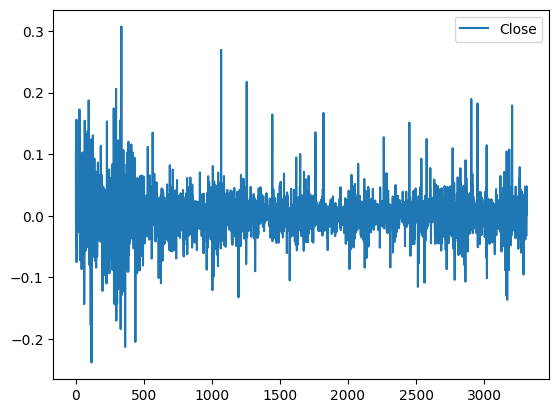

In [74]:
train_data_diff = train_data.diff().dropna()
train_data_diff.plot(y="Close")

It looks to be more stationary. 
We can also look the ACF and PACF plots of the first difference time to check the stationarity .

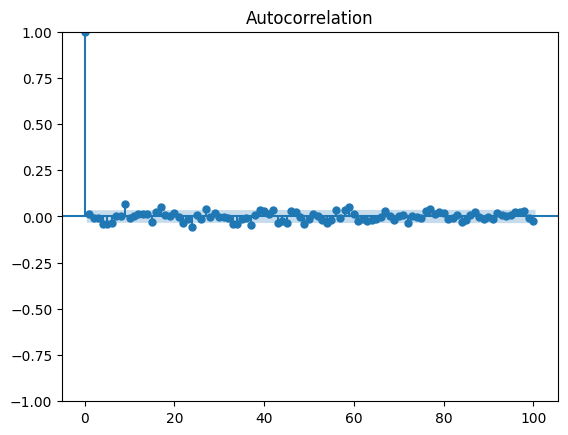

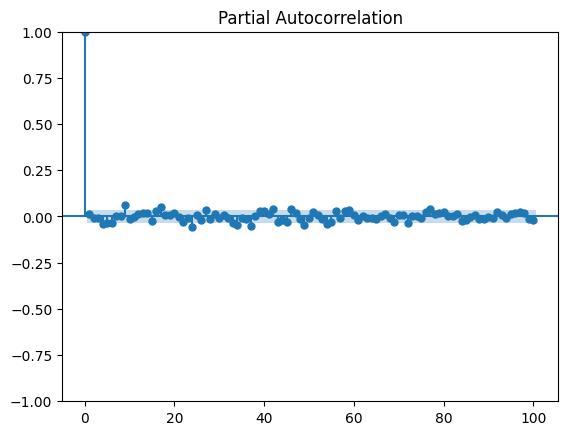

In [75]:
acf_diff = plot_acf(train_data_diff['Close'], lags=100)
pacf_diff = plot_pacf(train_data_diff['Close'], lags=100)

We can also quantify the result by running the ADF test on this transformation series.

In [76]:
adf_test = adfuller(train_data_diff['Close'])
print(f'p-value: {adf_test[1]}')
     

p-value: 2.271284921821811e-19


The p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values so the data is non-stationary.

We aply second difference time

<AxesSubplot: >

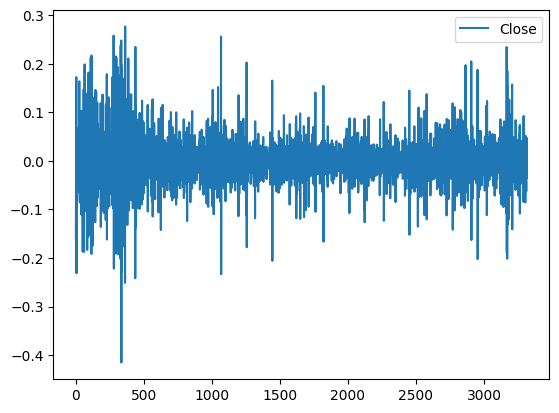

In [77]:
train_data_diff2 = train_data_diff.diff().dropna()
train_data_diff2.plot(y="Close")

In [78]:
adf_test2 = adfuller(train_data_diff2['Close'])
print(f'p-value: {adf_test2[1]}')

p-value: 3.967732403230748e-30


The behavior of the series we're working with is totally random. Even applying second differences, it does not have a stationary behavior. 

However, we can try to predict with an ARIMA model and see its forecast.

Step 2: Determine ARIMA models parameters p,q  

Step 3: Fit the ARIMA model

In [79]:
from statsmodels.tsa.arima.model import ARIMA


In [80]:

arima = ARIMA(train_data['Close'], order=(3,2,1))
arima_fit = arima.fit()
arima_fit.summary()

C:\Users\julie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 3315
Model:                 ARIMA(3, 2, 1)   Log Likelihood                6398.469
Date:                Mon, 29 Jan 2024   AIC                         -12786.939
Time:                        00:03:02   BIC                         -12756.411
Sample:                             0   HQIC                        -12776.013
                               - 3315                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0121      0.012      0.983      0.326      -0.012       0.036
ar.L2         -0.0070      0.011     -0.668      0.504      -0.028       0.014
ar.L3         -0.0070      0.013     -0.541      0.588      -0.032       0.018
ma.L1         -0.9999      0.030    -32.894      0.000      -1.060      -0.940
sigma2         0.0012   3.89e-05     31.514      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             10451.94
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Step 4: Make time series predictions

<AxesSubplot: >

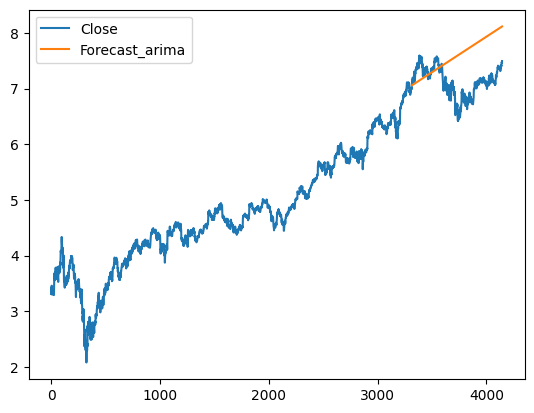

In [81]:
forecast = arima_fit.forecast(len(test_data))

data['Forecast_arima']  = [None]*len(train_data) + list(forecast)

data.plot(y=['Close', 'Forecast_arima'])

We can try Auto fit ARIMA model

In [82]:
import pmdarima as pm

In [83]:
auto_arima = pm.auto_arima(train_data['Close'], stepwise=False, seasonal=False)
auto_arima

ARIMA(order=(5, 1, 0), scoring_args={}, suppress_warnings=True)

In [84]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3315
Model:               SARIMAX(5, 1, 0)   Log Likelihood                6410.159
Date:                Mon, 29 Jan 2024   AIC                         -12806.318
Time:                        00:03:38   BIC                         -12763.576
Sample:                             0   HQIC                        -12791.021
                               - 3315                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.001      1.980      0.048    1.24e-05       0.002
ar.L1          0.0102      0.013      0.812      0.417      -0.014       0.035
ar.L2         -0.0085      0.011     -0.803      0.422      -0.029       0.012
ar.L3         -0.0071      0.013     -0.538      0.591      -0.033       0.019
ar.L4         -0.0410      0.011     -3.588      0.000      -0.063      -0.019
ar.L5         -0.0380      0.011     -3.479      0.001      -0.059      -0.017
sigma2         0.0012   1.35e-05     90.260      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             10282.71
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot: >

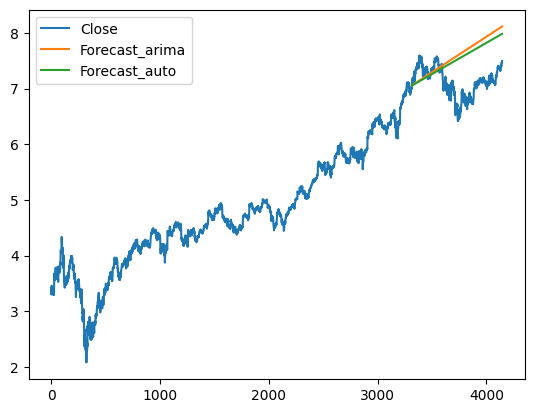

In [85]:
forecast_auto = auto_arima.predict(n_periods=len(test_data))

data['Forecast_auto']  = [None]*len(train_data) + list(forecast_auto)

data.plot(y=['Close', 'Forecast_arima', 'Forecast_auto'])

Step 5: Evaluate model predictions

In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [87]:
mae = mean_absolute_error(test_data['Close'], forecast)
mape = mean_absolute_percentage_error(test_data['Close'], forecast)
rmse = np.sqrt(mean_squared_error(test_data['Close'], forecast))

print(f' mae manual: {mae} mape manual: {mape} rmse manual: {rmse} ')

 mae manual: 0.5545882559407119 mape manual: 0.07922761904551034 rmse manual: 0.6501493133651518 


In [88]:
mae = mean_absolute_error(test_data['Close'], forecast_auto)
mape = mean_absolute_percentage_error(test_data['Close'], forecast_auto)
rmse = np.sqrt(mean_squared_error(test_data['Close'], forecast_auto))

print(f' mae auto: {mae} mape auto: {mape} rmse auto: {rmse} ')

 mae auto: 0.4993883172203468 mape auto: 0.07133700946249157 rmse auto: 0.5803814534139407 


# Time series forecasting with Prophet 

In [89]:
import prophet as prophet

In [90]:
prophet_data = pd.DataFrame({'ds': df.Date, 'y': df.Close})

In [91]:
prophet_data["ds"] = prophet_data["ds"].dt.date


In [92]:
prophet_data.head()

,ds,y
0,2007-08-10,27.616430
1,2007-08-13,30.668777
2,2007-08-14,29.099005
3,2007-08-15,27.674574
4,2007-08-16,27.228834


In [93]:
model = prophet.Prophet()
model.fit(prophet_data)

00:03:47 - cmdstanpy - INFO - Chain [1] start processing
00:03:48 - cmdstanpy - INFO - Chain [1] done processing


Set the period for train

In [94]:
future_prophet = model.make_future_dataframe(periods=len(test_data))

forecast_prophet = model.predict(future_prophet)
forecast_prophet

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-08-10,19.826592,-140.829248,224.535374,19.826592,19.826592,24.986088,24.986088,24.986088,-1.093178,-1.093178,-1.093178,26.079266,26.079266,26.079266,0.0,0.0,0.0,44.812681
1,2007-08-13,19.931088,-134.336691,235.681415,19.931088,19.931088,25.972518,25.972518,25.972518,-1.529529,-1.529529,-1.529529,27.502047,27.502047,27.502047,0.0,0.0,0.0,45.903606
2,2007-08-14,19.965920,-128.586783,221.074043,19.965920,19.965920,26.139574,26.139574,26.139574,-1.549744,-1.549744,-1.549744,27.689318,27.689318,27.689318,0.0,0.0,0.0,46.105495
3,2007-08-15,20.000753,-136.657068,221.182552,20.000753,20.000753,26.097247,26.097247,26.097247,-1.656895,-1.656895,-1.656895,27.754142,27.754142,27.754142,0.0,0.0,0.0,46.097999
4,2007-08-16,20.035585,-133.790740,236.839750,20.035585,20.035585,26.126806,26.126806,26.126806,-1.583952,-1.583952,-1.583952,27.710758,27.710758,27.710758,0.0,0.0,0.0,46.162391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4968,2026-04-30,1026.513295,656.456151,1409.291716,718.382544,1352.410634,-13.051643,-13.051643,-13.051643,-1.583952,-1.583952,-1.583952,-11.467691,-11.467691,-11.467691,0.0,0.0,0.0,1013.461652
4969,2026-05-01,1026.354810,647.606465,1386.767220,717.500328,1352.517814,-13.306469,-13.306469,-13.306469,-1.093178,-1.093178,-1.093178,-12.213291,-12.213291,-12.213291,0.0,0.0,0.0,1013.048340
4970,2026-05-02,1026.196324,671.860168,1401.907393,716.618113,1352.872582,-9.154828,-9.154828,-9.154828,3.706650,3.706650,3.706650,-12.861478,-12.861478,-12.861478,0.0,0.0,0.0,1017.041496
4971,2026-05-03,1026.037839,647.186034,1393.479222,715.802702,1353.227350,-9.707422,-9.707422,-9.707422,3.706649,3.706649,3.706649,-13.414071,-13.414071,-13.414071,0.0,0.0,0.0,1016.330417


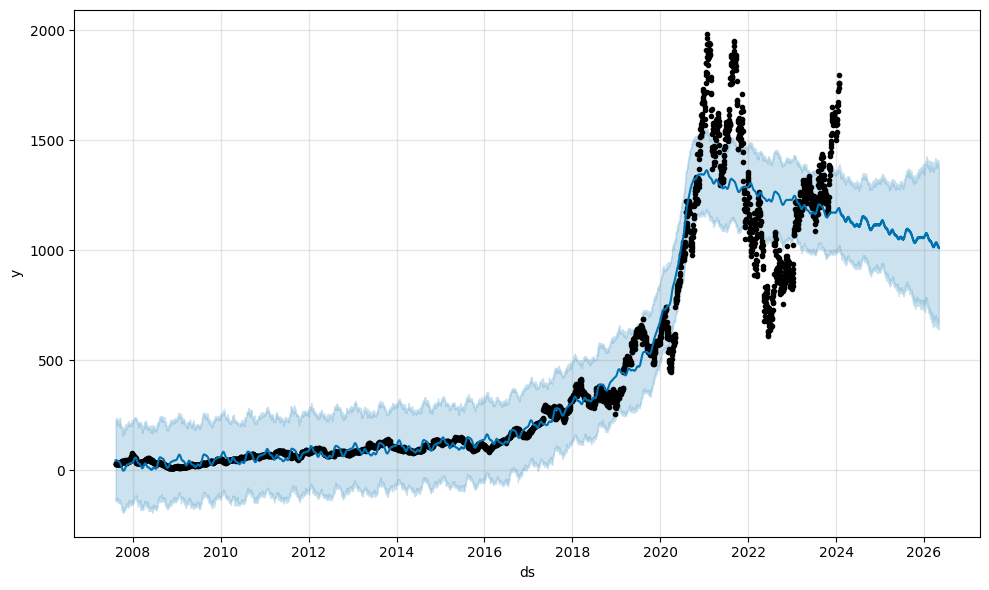

In [95]:
model.plot(forecast_prophet)
plt.show()

We can look trend, seasonal, period components

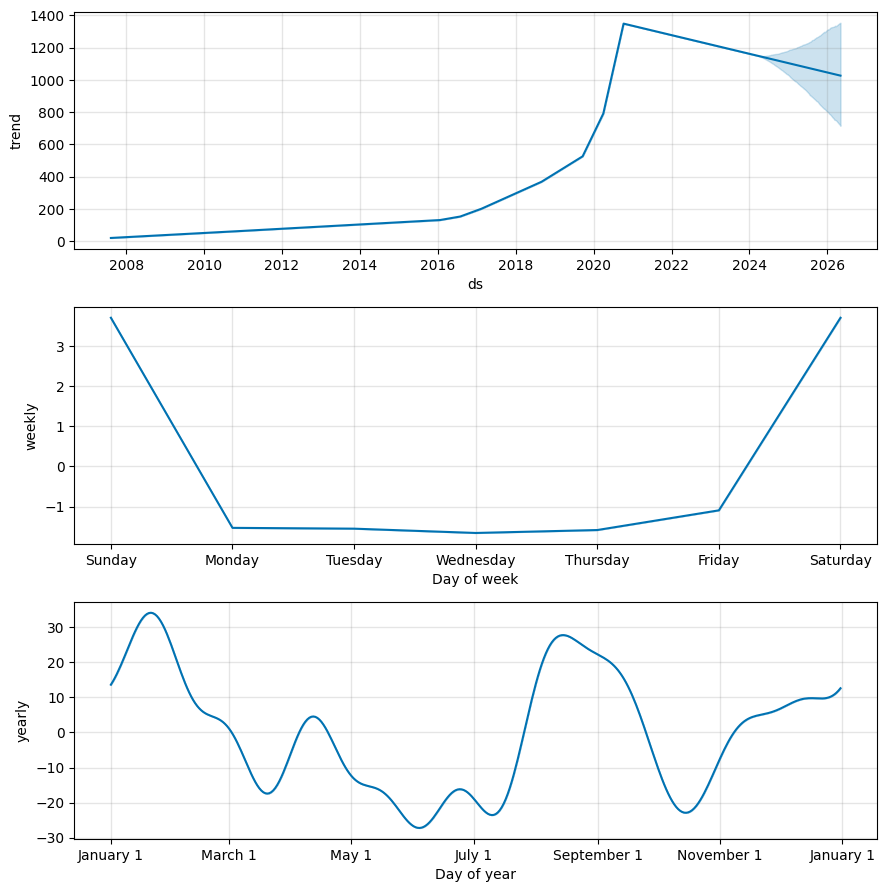

In [96]:
model.plot_components(forecast_prophet)
plt.show()

To assess how well our model works, we will perform a cross validation.

In [97]:
from prophet.diagnostics import cross_validation

prophet_cv = cross_validation(model,
                              initial='730 days',
                              period='180 days',
                              horizon='365 days')
prophet_cv

  0%|          | 0/28 [00:00<?, ?it/s]

00:03:59 - cmdstanpy - INFO - Chain [1] start processing
00:03:59 - cmdstanpy - INFO - Chain [1] done processing
00:03:59 - cmdstanpy - INFO - Chain [1] start processing
00:03:59 - cmdstanpy - INFO - Chain [1] done processing
00:03:59 - cmdstanpy - INFO - Chain [1] start processing
00:03:59 - cmdstanpy - INFO - Chain [1] done processing
00:04:00 - cmdstanpy - INFO - Chain [1] start processing
00:04:00 - cmdstanpy - INFO - Chain [1] done processing
00:04:00 - cmdstanpy - INFO - Chain [1] start processing
00:04:00 - cmdstanpy - INFO - Chain [1] done processing
00:04:00 - cmdstanpy - INFO - Chain [1] start processing
00:04:01 - cmdstanpy - INFO - Chain [1] done processing
00:04:01 - cmdstanpy - INFO - Chain [1] start processing
00:04:01 - cmdstanpy - INFO - Chain [1] done processing
00:04:01 - cmdstanpy - INFO - Chain [1] start processing
00:04:01 - cmdstanpy - INFO - Chain [1] done processing
00:04:02 - cmdstanpy - INFO - Chain [1] start processing
00:04:02 - cmdstanpy - INFO - Chain [1]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2009-10-07,36.143132,31.492447,40.306904,39.486664,2009-10-06
1,2009-10-08,36.102500,31.607448,40.462237,39.438210,2009-10-06
2,2009-10-09,36.045840,31.754524,40.590190,40.368443,2009-10-06
3,2009-10-12,35.449405,30.674146,40.242774,39.903320,2009-10-06
4,2009-10-13,35.245613,30.878009,39.719576,40.533173,2009-10-06
...,...,...,...,...,...,...
7038,2024-01-22,1402.614748,1162.088707,1654.658837,1756.300049,2023-01-26
7039,2024-01-23,1403.308692,1168.409388,1664.506705,1759.910034,2023-01-26
7040,2024-01-24,1405.420272,1171.903210,1632.270188,1762.699951,2023-01-26
7041,2024-01-25,1406.719099,1167.344701,1646.961934,1738.800049,2023-01-26


In [98]:
from prophet.diagnostics import performance_metrics

prophet_performance = performance_metrics(prophet_cv)
prophet_performance

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,51709.111013,227.396374,112.047082,0.198625,0.134752,0.187364,0.323011
1,38 days,52222.235575,228.521849,112.618171,0.200675,0.136733,0.188879,0.321654
2,39 days,52104.204887,228.263455,112.349027,0.201201,0.137187,0.188841,0.321094
3,40 days,50879.965251,225.565878,110.984228,0.200658,0.137187,0.188315,0.319318
4,41 days,50137.129762,223.913219,109.942557,0.200979,0.137485,0.188281,0.321591
...,...,...,...,...,...,...,...,...
324,361 days,196320.278440,443.080442,242.419969,0.351163,0.267744,0.323666,0.331414
325,362 days,197798.376412,444.745294,244.187203,0.352450,0.268462,0.324854,0.332031
326,363 days,199757.099357,446.941942,245.604590,0.352902,0.268846,0.325563,0.337470
327,364 days,201963.539958,449.403538,247.181881,0.353228,0.268846,0.325964,0.342330


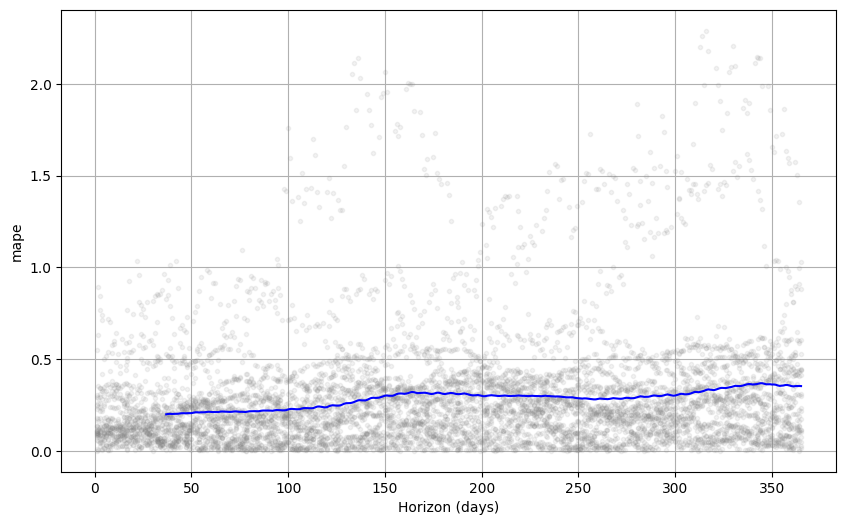

In [99]:
from prophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(prophet_cv, metric='mape')

The accuracy of predictions decreases as the prediction horizon expands. We see that the error for the first few days is 22% and increases to almost 36%.

# Prediction with LSTM network

LSTMs are sensitive to the scale of the input data.It can be a good practice to rescale the data to the range of 0-to-1

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [114]:
ticker = yf.Ticker("MELI")
df = ticker.history(period="max")

In [115]:
df.reset_index(inplace=True)

In [116]:
price = df[['Close']]

Normalize the dataset

In [117]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(price)

Split into train and test 

In [118]:
train_size = int(len(data) * 0.70)
test_size = len(data) * 0.30
train, test = data[0:train_size,:], data[train_size:len(data),:]

Reshape input to be [samples, time steps, features]

In [125]:
time_step = 10

def create_dataset(data, time_step):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)


In [127]:
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

In [121]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Create and fit the LSTM network


In [123]:
from  tensorflow.keras.models import Sequential
from  tensorflow.keras.layers import Dense
from  tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [128]:
model = Sequential()
model.add(LSTM(4, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
2889/2889 - 9s - loss: 1.8172e-04 - 9s/epoch - 3ms/step
Epoch 2/10
2889/2889 - 7s - loss: 2.9533e-05 - 7s/epoch - 2ms/step
Epoch 3/10
2889/2889 - 7s - loss: 2.1765e-05 - 7s/epoch - 2ms/step
Epoch 4/10
2889/2889 - 7s - loss: 1.7507e-05 - 7s/epoch - 2ms/step
Epoch 5/10
2889/2889 - 7s - loss: 1.4154e-05 - 7s/epoch - 2ms/step
Epoch 6/10
2889/2889 - 7s - loss: 1.2880e-05 - 7s/epoch - 2ms/step
Epoch 7/10
2889/2889 - 6s - loss: 1.1433e-05 - 6s/epoch - 2ms/step
Epoch 8/10
2889/2889 - 7s - loss: 1.0800e-05 - 7s/epoch - 2ms/step
Epoch 9/10
2889/2889 - 6s - loss: 1.0521e-05 - 6s/epoch - 2ms/step
Epoch 10/10
2889/2889 - 7s - loss: 9.4308e-06 - 7s/epoch - 2ms/step


Predictions

In [129]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

39/39 [==============================] - 0s 1ms/step


Invert predictions

In [130]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

Plotting

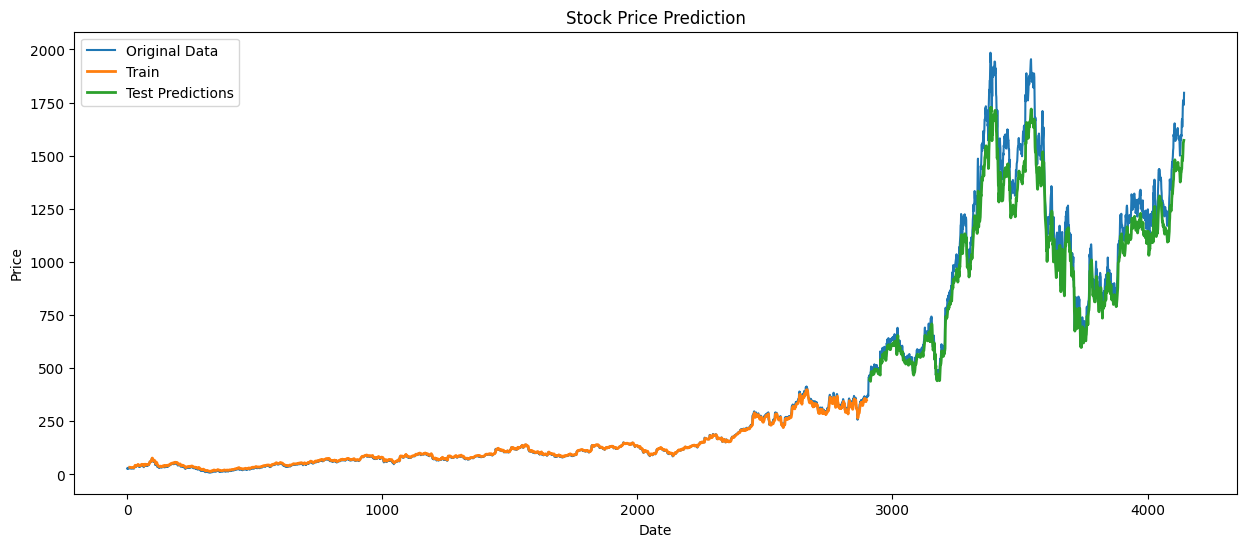

In [133]:
train_plot = np.empty_like(data)
train_plot[:, :] = np.nan
train_plot[time_step:len(train_predict)+time_step, :] = train_predict
# shift test predictions for plotting
test_plot = np.empty_like(data)
test_plot[:, :] = np.nan
test_plot[len(train_predict)+(time_step*2)+1:len(data)-1, :] = test_predict
# plot baseline and predictions
plt.figure(figsize=(15,6))
plt.plot(scaler.inverse_transform(data), label='Original Data')
plt.plot(train_plot, label='Train', linewidth = 2)
plt.plot(test_plot, label='Test Predictions', linewidth = 2)
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()